# Using PyTorch to Build LeNet

LeNet was developed in 1998 and is one of the first Convolutional Neural Network models. The model is especially good at image recognition.

The notebook implements LeNet-5 which contains 5 layers. 2 convolutional and 3 fully-connected.

This code is referenced in Mastering PyTorch but updated to run on a GPU in Google Colab.

In [1]:
# import PyTorch and python libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

# comment out if running on gpu
# torch.use_deterministic_algorithms(True) # for reproducibility

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    # layer 1 - 3 input image channels, 6 output feature maps
    # and 5x5 conv kernel
    self.cn1 = nn.Conv2d(3, 6, 5)

    # layer 2 - 6 input image channels, 16 output feature maps
    # and 5x5 conv kernel
    self.cn2 = nn.Conv2d(6,16,5)

    # layers 3 - 5 fully-connected size 120, 84, and 10
    # with 5x5 as the spatial dimension
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)


  def forward(self, x):
    # Convolution with 5x5 kernel
    x = F.relu(self.cn1(x))
    # max pooling over a (2,2) windows
    x = F.max_pool2d(x, (2,2))

    x = F.relu(self.cn2(x))
    x = F.max_pool2d(x, (2,2))

    # flatten spatial and depth dimensions into single vector
    x = x.view(-1, self.flatten_features(x))

    # fully connected operations
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

  def flatten_features(self, x):
    # all except the first (batch) dim
    size = x.size()[1:]
    num_feats = 1
    for s in size:
      num_feats *= s
    return num_feats

In [4]:
lenet = LeNet().to(device)
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
# build function for training loop
def train(model, train_dataloader, optim, epoch):
  loss_total = 0.0
  for i, data in enumerate(train_dataloader, 0):

    # get inputs from data [inputs, labels]
    img, label = data
    img, label = img.to(device), label.to(device)

    # zero out the parameter gradients
    optim.zero_grad()

    # forward - pass + backward-pass + optimization - step
    op = model(img)
    loss = nn.CrossEntropyLoss()(op, label)
    loss.backward()
    optim.step()

    # update loss value for current epoch
    loss_total += loss.item()
    # print at 1000 mini-batch intervals
    if (i + 1) % 1000 == 0:
      print(f'[Epoch number: {epoch + 1}, Mini-batches: {i +1 }] \ loss: {loss_total / 200}')
      loss_total = 0.0

In [6]:
# evaluation / test loop
def test(model, test_dataloader):
  success = 0
  counter = 0
  with torch.no_grad():
    for data in test_dataloader:
      img, label = data
      img, label = img.to(device), label.to(device)
      op = model(img)
      _, pred = torch.max(op.data, 1)
      counter += label.size(0)
      success += (pred == label).sum().item()
    print(f'LeNet Accuracy on 10000 images from test dataset: {(success / counter) * 100:.2f}%')




In [7]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32,4),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True, download=True, transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


In [8]:
test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]
)

testset = torchvision.datasets.CIFAR10(root='./data',
                                        train=False, download=True, transform=test_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [9]:
def img_show(img):
  # denormalize the image
  img = img/2 + 0.5
  npimage = img.numpy()
  plt.imshow(np.transpose(npimage, (1,2,0)))
  plt.show()

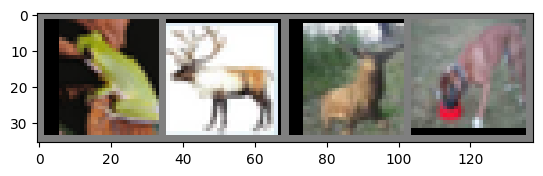

 frog || deer || deer || dog


In [10]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

n = 4

img_show(torchvision.utils.make_grid(images[:n]))
print(' '+' || '.join(classes[labels[j]] for j in range(n)))

In [11]:
# define optimizer
optim = torch.optim.Adam(lenet.parameters(), lr = 0.001)

# execute training loop for multiple epochs
for epoch in range(20):
  train(lenet, trainloader, optim, epoch)
  test(lenet, testloader)
  print()
print('Finished Training')


[Epoch number: 1, Mini-batches: 1000] \ loss: 9.90738964498043
[Epoch number: 1, Mini-batches: 2000] \ loss: 8.778030918240548
[Epoch number: 1, Mini-batches: 3000] \ loss: 8.413589752912522
[Epoch number: 1, Mini-batches: 4000] \ loss: 8.133448733985425
[Epoch number: 1, Mini-batches: 5000] \ loss: 7.9443953555822375
[Epoch number: 1, Mini-batches: 6000] \ loss: 7.74602963089943
LeNet Accuracy on 10000 images from test dataset: 45.63%

[Epoch number: 2, Mini-batches: 1000] \ loss: 7.59565857231617
[Epoch number: 2, Mini-batches: 2000] \ loss: 7.367192136049271
[Epoch number: 2, Mini-batches: 3000] \ loss: 7.427239284813404
[Epoch number: 2, Mini-batches: 4000] \ loss: 7.335821777582169
[Epoch number: 2, Mini-batches: 5000] \ loss: 7.370644254088401
[Epoch number: 2, Mini-batches: 6000] \ loss: 7.1985158798098565
LeNet Accuracy on 10000 images from test dataset: 50.87%

[Epoch number: 3, Mini-batches: 1000] \ loss: 7.104989108294249
[Epoch number: 3, Mini-batches: 2000] \ loss: 7.04150

In [12]:
# save model
model_path = './cifar_model.pth'
torch.save(lenet.state_dict(), model_path)

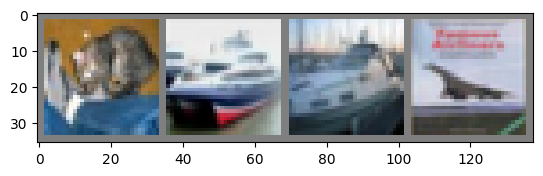

Labels:		cat             ship            ship            plane          
Prediction:	cat            car            ship           plane          


In [13]:
# load the saved model and checks results against test dataset
test_iter = iter(testloader)
img, label = next(test_iter)

# print image and label
img_show(torchvision.utils.make_grid(img[:4]))


print(f"Labels:\t\t{' '.join(f'{classes[label[j]]:15}' for j in range(4))}")

# load model
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

# model inference
op = lenet_cached(img)

# print predictions
_, pred = torch.max(op, 1)
print(f"Prediction:\t{''.join(f'{classes[pred[j]]:15}' for j in range(4))}")

In [18]:
# show overall accuracy
success = 0
counter = 0

with torch.no_grad():
  for data in testloader:
    img, label = data
    op = lenet_cached(img)
    _, pred = torch.max(op.data, 1)
    counter += label.size(0)
    success += (pred == label).sum().item()
  print(f'Model accuracy on 10000 images from test data: {100* success / counter:.2f}%')


Model accuracy on 10000 images from test data: 63.41%


In [17]:
# accuracy by class
class_success = list(0. for i in range(10))
class_counter = list(0. for i in range(10))

with torch.no_grad():
  for data in testloader:
    img, label = data
    op = lenet_cached(img)
    _, pred = torch.max(op.data, 1)
    c = (pred == label).squeeze()
    for i in range(10000):
      label_curr = label[i]
      class_success[label_curr] += c[i].item()
      class_counter[label_curr] += 1

for i in range(10):
  print(f'Model accuracy for class {classes[i]}\t{100*class_success[i] / class_counter[i]:.2f}%')


Model accuracy for class plane	62.70%
Model accuracy for class car	77.70%
Model accuracy for class bird	41.80%
Model accuracy for class cat	37.10%
Model accuracy for class deer	58.80%
Model accuracy for class dog	65.60%
Model accuracy for class frog	81.90%
Model accuracy for class horse	57.20%
Model accuracy for class ship	80.70%
Model accuracy for class truck	70.60%


The LeNet model performs relatively well and is very good at some classes but more at others. The next notebook covers the AlexNet model .